# Classification (Logistic Regression, LDA, QDA)


Здравствуйте, на этом семинаре вы познакомитесь с задачей Классификации, Линейным и Квадратичным Дискриминантным Анализом (LDA & QDA), Логичестической регрессией, а так же познакомитесь с различными метрик классификации.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

[Устройство ROC-curve и ROC AUC](https://alexanderdyakonov.wordpress.com/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/)\
[Построение многоклассового ROC-curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)\
[Построение PR-curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

## Задача 1


### Введение в LDA

Для начала научимся применять [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html), подключим его

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from math import log
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import  precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, average_precision_score



Сгенерируйте выборки $X_{0}\sim\mathcal{N}(\mu_{0},\Sigma_{0})$ объема $n_{0}=100$, где $\Sigma_{0}=\begin{pmatrix}2 & 0\\ 0 & 0.5\end{pmatrix}, \mu_{0}=(0,0)$ и $X_{1}\sim\mathcal{N}(\mu_{1},\Sigma_{1})$ объема $n_{1}=100$, где $\Sigma_{1}=\begin{pmatrix}0.5 & 0\\ 0 & 2\end{pmatrix}, \mu_{0}=(1,1)$, и изобразите их на плоскости. Попробуйте визуально разделить эти два класса

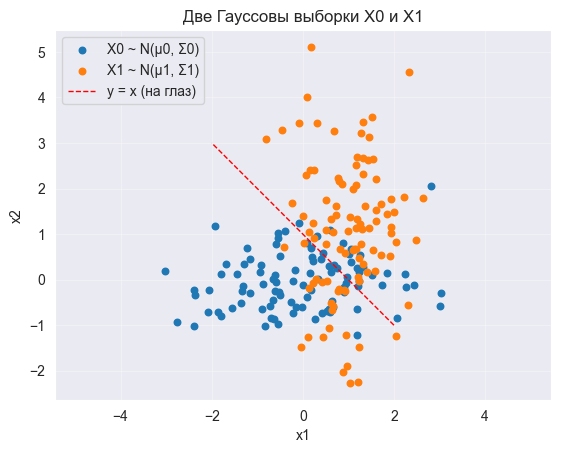

In [7]:
rng = np.random.default_rng(42)

n0, n1 = 100, 100
mu0 = np.array([0.0, 0.0])
Sigma0 = np.array([[2.0, 0.0],
                   [0.0, 0.5]])

mu1 = np.array([1.0, 1.0])
Sigma1 = np.array([[0.5, 0.0],
                   [0.0, 2.0]])

X0 = rng.multivariate_normal(mu0, Sigma0, size=n0)
X1 = rng.multivariate_normal(mu1, Sigma1, size=n1)

fig = plt.figure()
plt.scatter(X0[:, 0], X0[:, 1], s=22, label="X0 ~ N(μ0, Σ0)")
plt.scatter(X1[:, 0], X1[:, 1], s=22, label="X1 ~ N(μ1, Σ1)")

plt.plot([2, -2], [-1, 3], "--", lw=1, label="y = x (на глаз)", color="red")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Две Гауссовы выборки X0 и X1")
plt.axis("equal")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


Объедините выборки в единый набор данных и разделите их на два класса, добавив столбец label. Примените классификатор LDA к этим выборкам и оцените качество классификации

         x1        x2  label
0  0.430935 -0.735380      0
1  1.061298  0.665080      0
2 -2.759180 -0.920780      0
3  0.180794 -0.223617      0
4 -0.023760 -0.603193      0
Test accuracy: 0.7
Confusion matrix (rows=true, cols=pred):
 [[21  9]
 [ 9 21]]
Classification report:
               precision    recall  f1-score   support

           0      0.700     0.700     0.700        30
           1      0.700     0.700     0.700        30

    accuracy                          0.700        60
   macro avg      0.700     0.700     0.700        60
weighted avg      0.700     0.700     0.700        60

5-fold CV accuracy: 0.740 ± 0.041


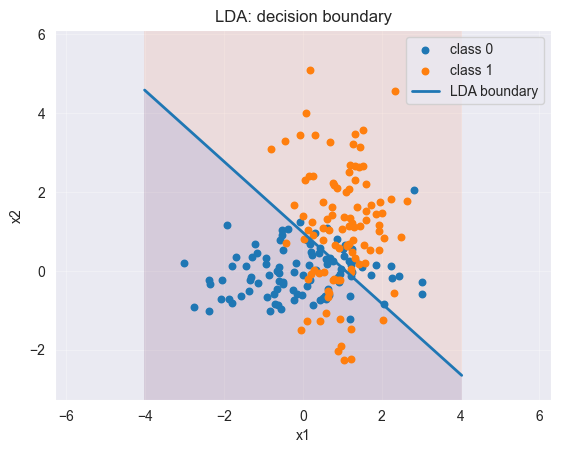

In [16]:

#clf = LinearDiscriminantAnalysis()
X = np.vstack([X0, X1])
y = np.concatenate([np.zeros(len(X0), dtype=int), np.ones(len(X1), dtype=int)])
df = pd.DataFrame({'x1': X[:,0], 'x2': X[:,1], 'label': y})
print(df.head())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=52)

clf = LinearDiscriminantAnalysis() 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred, digits=3))


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
cv_acc = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
print(f"5-fold CV accuracy: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")

fig = plt.figure()

x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 400),
                       np.linspace(x2_min, x2_max, 400))
grid = np.c_[xx1.ravel(), xx2.ravel()]
zz = clf.predict(grid).reshape(xx1.shape)
plt.contourf(xx1, xx2, zz, alpha=0.15, levels=[-0.5,0.5,1.5])

plt.scatter(X[y==0,0], X[y==0,1], s=22, label='class 0')
plt.scatter(X[y==1,0], X[y==1,1], s=22, label='class 1')

w = clf.coef_[0]; b = clf.intercept_[0]
if abs(w[1]) > 1e-12:
    xs = np.linspace(x1_min, x1_max, 400)
    ys = -(w[0]*xs + b)/w[1]
    plt.plot(xs, ys, '-', lw=2, label='LDA boundary')

plt.xlabel('x1'); plt.ylabel('x2'); plt.title('LDA: decision boundary')
plt.legend(); plt.axis('equal'); plt.grid(alpha=0.3)
plt.show()

Так же, как и любая линейная модель, LDA строит разделяющую линейную поверхность вида $\overline{\omega}\overline{X}+b=0$ (для 2х классов). Данная поверхность соответствует стандартному порогу $t=\frac{1}{2}$. Подумайте, как меняется поверхность при выборе другого порога.


Изобразите построенную LDA поверхность вручную с помощью полей *.coef_* и *.intercept_* класса LinearDiscriminantAnalysis, а так же с помощью встроенных методов [DecisionBoundaryDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html) или [plot_decision_region](https://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/)

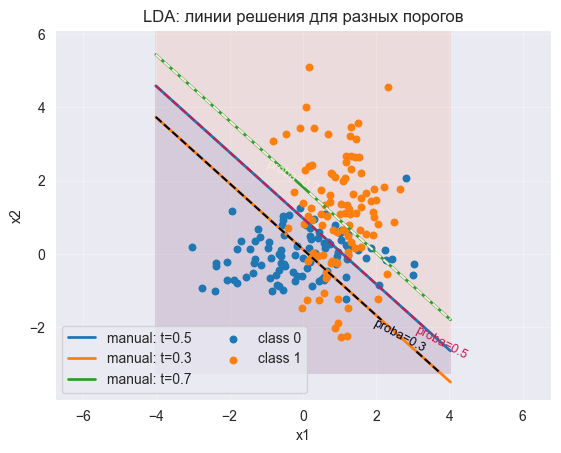

In [24]:
w = clf.coef_[0]
b = clf.intercept_[0]

x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 800),
                       np.linspace(x2_min, x2_max, 800))
grid = np.c_[xx1.ravel(), xx2.ravel()]

fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf, X, response_method="predict", 
    plot_method="contourf", levels=[-0.5, 0.5, 1.5], alpha=0.15, ax=ax
)


# Ручные прямые для разных порогов
def plot_line_for_t(ax, t, label):
    bt = b - log(t/(1-t))  # сдвиг intercept под произвольный порог
    if abs(w[1]) > 1e-12:
        xs = np.linspace(x1_min, x1_max, 400)
        ys = -(w[0]*xs + bt)/w[1]
        ax.plot(xs, ys, lw=2, label=label)
    else:
        x_vert = -bt / w[0]
        ax.axvline(x_vert, lw=2, label=label)

for t, lab in [(0.5, "manual: t=0.5"), (0.3, "manual: t=0.3"), (0.7, "manual: t=0.7")]:
    plot_line_for_t(ax, t, lab)
    
    
proba = clf.predict_proba(grid)[:, 1].reshape(xx1.shape)
cs = ax.contour(xx1, xx2, proba, levels=[0.3, 0.5, 0.7],
                linestyles=["--", "--", "--"], linewidths=1.5)
ax.clabel(cs, fmt=lambda v: f"proba={v:.1f}", inline=True, fontsize=9)

# 6) Точки
ax.scatter(X[y==0,0], X[y==0,1], s=22, label='class 0')
ax.scatter(X[y==1,0], X[y==1,1], s=22, label='class 1')

ax.set_xlabel('x1'); ax.set_ylabel('x2')
ax.set_title('LDA: линии решения для разных порогов')
ax.legend(ncol=2); ax.axis('equal'); ax.grid(alpha=0.3)
plt.show()



Используя обученные веса классификатора, постройте несколько разделяющих поверхностей при различных параметрах порога t

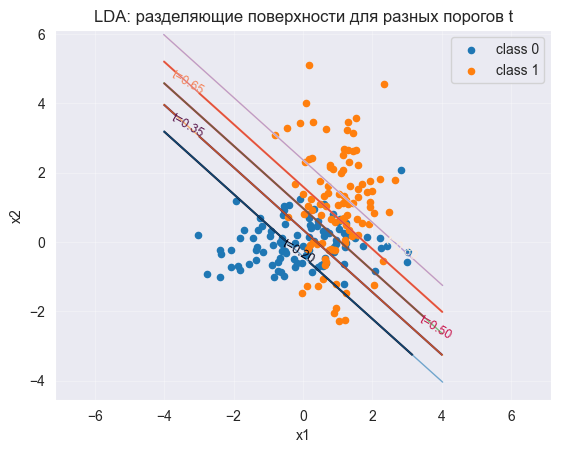

In [26]:
Ts = [0.2, 0.35, 0.5, 0.65, 0.8]
x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 800),
                       np.linspace(x2_min, x2_max, 800))
grid = np.c_[xx1.ravel(), xx2.ravel()]
proba = clf.predict_proba(grid)[:, 1].reshape(xx1.shape)

fig, ax = plt.subplots()

# Изолинии вероятности P(y=1|x)=t
cs = ax.contour(xx1, xx2, proba, levels=Ts, linewidths=1.5)
ax.clabel(cs, fmt=lambda v: f"t={v:.2f}", inline=True, fontsize=9)

# границы "вручную" (параллельные прямые): w^T x + b_t = 0
if abs(w[1]) > 1e-12:
    xs = np.linspace(x1_min, x1_max, 400)
    for t in Ts:
        bt = b - log(t/(1-t))
        ys = -(w[0]*xs + bt)/w[1]
        ax.plot(xs, ys, lw=1, alpha=0.6)
else:
    for t in Ts:
        bt = b - log(t/(1-t))
        x_vert = -bt / w[0]
        ax.axvline(x_vert, lw=1, alpha=0.6)

# Точки данных
ax.scatter(X[y==0,0], X[y==0,1], s=20, label='class 0')
ax.scatter(X[y==1,0], X[y==1,1], s=20, label='class 1')

ax.set_xlabel('x1'); ax.set_ylabel('x2')
ax.set_title('LDA: разделяющие поверхности для разных порогов t')
ax.legend(); ax.axis('equal'); ax.grid(alpha=0.3)
plt.show()

На сколько ваше предположение о виде прямой соответствует ответу LDA?

+- я попал)

### Метрики

Посчитайте вручную значение метрик [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html), [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html), [F1](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) (для порога $t=\dfrac{1}{2}$), а затем сравните со встроенными функциями sklearn

In [30]:
proba = clf.predict_proba(X_test)[:, 1]
y_pred05 = (proba >= 0.5).astype(int)
assert np.array_equal(y_pred, y_pred05), "y_pred не соответствует порогу 0.5"

# Подсчёт TP/TN/FP/FN вручную
tp = int(np.sum((y_test == 1) & (y_pred == 1)))
tn = int(np.sum((y_test == 0) & (y_pred == 0)))
fp = int(np.sum((y_test == 0) & (y_pred == 1)))
fn = int(np.sum((y_test == 1) & (y_pred == 0)))
n  = int(y_test.size)

acc = (tp + tn) / n
prec = tp / (tp + fp) if (tp + fp) > 0 else float('nan')
rec  = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else float('nan')

print(f"Manual counts: TP={tp}, FP={fp}, TN={tn}, FN={fn}, N={n}")
print(f"Manual metrics (t=0.5): Accuracy={acc:.3f}  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}")

# Сравнение со sklearn (binary, pos_label=1)
print("sklearn:",
      f"Acc={accuracy_score(y_test, y_pred):.3f}",
      f"P={precision_score(y_test, y_pred, zero_division=0):.3f}",
      f"R={recall_score(y_test, y_pred, zero_division=0):.3f}",
      f"F1={f1_score(y_test, y_pred, zero_division=0):.3f}")

Manual counts: TP=21, FP=9, TN=21, FN=9, N=60
Manual metrics (t=0.5): Accuracy=0.700  Precision=0.700  Recall=0.700  F1=0.700
sklearn: Acc=0.700 P=0.700 R=0.700 F1=0.700


Постройте [ROC-curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) и [PR-curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) и посчитайте [площади](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) под эти кривыми


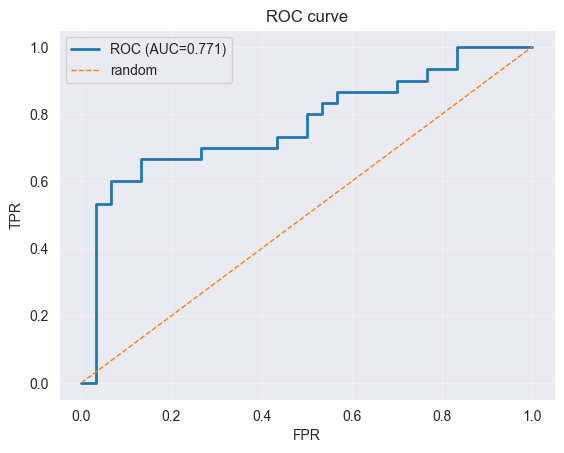

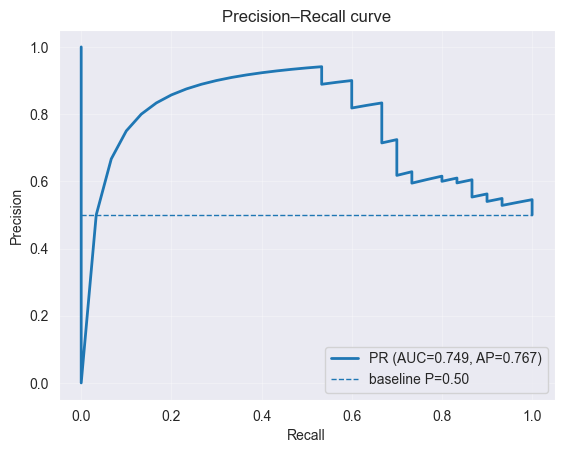

ROC AUC (auc) = 0.771111;  ROC AUC (roc_auc_score) = 0.771111
PR AUC (auc)   = 0.748818;  Average Precision (AP)   = 0.766546


In [33]:
y_score = clf.predict_proba(X_test)[:, 1]

# ROC
fpr, tpr, roc_th = roc_curve(y_test, y_score)  
roc_auc = auc(fpr, tpr)                        # ROC
roc_auc_chk = roc_auc_score(y_test, y_score)

# PR
prec, rec, pr_th = precision_recall_curve(y_test, y_score)
pr_auc = auc(rec, prec)                        # площадь под PR-кривой (trapz)
ap = average_precision_score(y_test, y_score)  # Average Precision

prevalence = y_test.mean()                     # baseline for PR

fig = plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], "--", lw=1, label="random")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curve"); plt.legend(); plt.grid(alpha=0.3)
plt.show()

fig = plt.figure()
plt.plot(rec, prec, lw=2, label=f"PR (AUC={pr_auc:.3f}, AP={ap:.3f})")
plt.hlines(prevalence, 0, 1, linestyles="--", lw=1, label=f"baseline P={prevalence:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall curve"); plt.legend(); plt.grid(alpha=0.3)
plt.show()

print(f"ROC AUC (auc) = {roc_auc:.6f};  ROC AUC (roc_auc_score) = {roc_auc_chk:.6f}")
print(f"PR AUC (auc)   = {pr_auc:.6f};  Average Precision (AP)   = {ap:.6f}")

Что вы можете сказать о качестве классификации модели LDA?

Your answer here

## Задача 2

Теперь научимся применять [QDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html)

In [34]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

Примените QDA к данным из первой задачи, оцените качество модели, сравните с LDA

QDA test accuracy: 0.733
QDA confusion (rows=true, cols=pred):
 [[21  9]
 [ 7 23]]
QDA classification report:
               precision    recall  f1-score   support

           0      0.750     0.700     0.724        30
           1      0.719     0.767     0.742        30

    accuracy                          0.733        60
   macro avg      0.734     0.733     0.733        60
weighted avg      0.734     0.733     0.733        60

QDA 5-fold CV accuracy: 0.825 ± 0.067

Сравнение LDA vs QDA (accuracy):
model  test_acc  cv_acc_mean  cv_acc_std
  LDA  0.700000        0.740    0.040620
  QDA  0.733333        0.825    0.067082


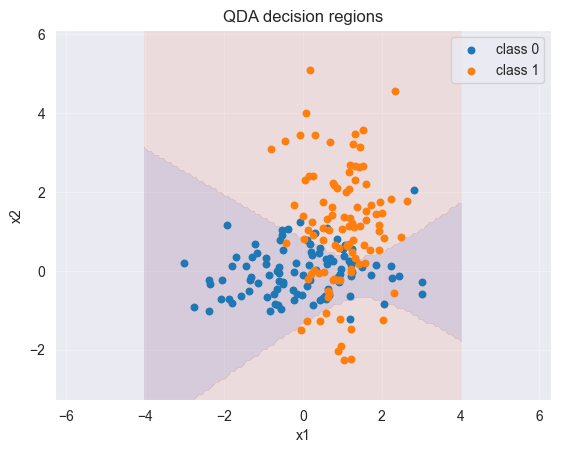

In [35]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

y_pred_qda = qda.predict(X_test)
acc_qda = accuracy_score(y_test, y_pred_qda)
print(f"QDA test accuracy: {acc_qda:.3f}")
print("QDA confusion (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred_qda))
print("QDA classification report:\n", classification_report(y_test, y_pred_qda, digits=3)) 

# QDA cross-val (та же схема, что и для LDA)
cv_acc_qda = cross_val_score(qda, X, y, cv=cv, scoring='accuracy')
print(f"QDA 5-fold CV accuracy: {cv_acc_qda.mean():.3f} ± {cv_acc_qda.std():.3f}")

# Сравнение с LDA на тех же данных
acc_lda = accuracy_score(y_test, y_pred) 
cv_acc_lda = cross_val_score(clf, X, y, cv=cv, scoring='accuracy') 

cmp = pd.DataFrame({
    "model": ["LDA", "QDA"],
    "test_acc": [acc_lda, acc_qda],
    "cv_acc_mean": [cv_acc_lda.mean(), cv_acc_qda.mean()],
    "cv_acc_std":  [cv_acc_lda.std(),  cv_acc_qda.std()]
})
print("\nСравнение LDA vs QDA (accuracy):")
print(cmp.to_string(index=False))

# Для наглядности: фон QDA (контуры классов) + точки
fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    qda, X, response_method="predict",
    plot_method="contourf", levels=[-0.5, 0.5, 1.5], alpha=0.15, ax=ax
)
ax.scatter(X[y==0,0], X[y==0,1], s=22, label='class 0')
ax.scatter(X[y==1,0], X[y==1,1], s=22, label='class 1')
ax.set_title("QDA decision regions")
ax.set_xlabel("x1"); ax.set_ylabel("x2")
ax.legend(); ax.axis("equal"); ax.grid(alpha=0.3)
plt.show()

Сделайте дисбаланс классов в первой задаче $n_{0}=25,n_{1}=250$

In [ ]:
#Your code here

Примените LDA и QDA. Постройте разделяющие поверхности.
Посчитайте метрики классификации и сравните две модели


LDA:
Accuracy=0.940  Precision=0.949  Recall=0.987  F1=0.967
Confusion (rows=true, cols=pred):
 [[ 4  4]
 [ 1 74]]

QDA:
Accuracy=0.928  Precision=0.937  Recall=0.987  F1=0.961
Confusion (rows=true, cols=pred):
 [[ 3  5]
 [ 1 74]]

Сравнение моделей (test metrics):
model  Accuracy  Precision   Recall       F1
  LDA  0.939759   0.948718 0.986667 0.967320
  QDA  0.927711   0.936709 0.986667 0.961039


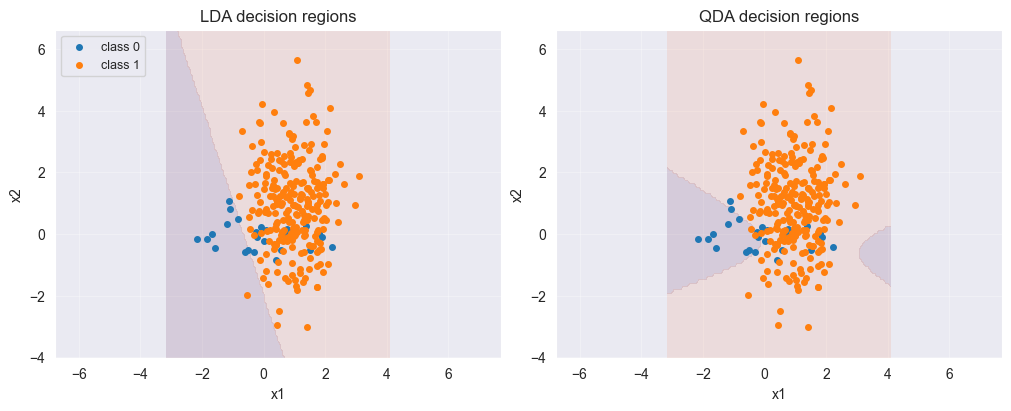

In [37]:
rng = np.random.default_rng(1488)
n0, n1 = 25, 250
mu0 = np.array([0.0, 0.0]); Sigma0 = np.array([[2.0, 0.0],[0.0, 0.5]])
mu1 = np.array([1.0, 1.0]); Sigma1 = np.array([[0.5, 0.0],[0.0, 2.0]])

X0 = rng.multivariate_normal(mu0, Sigma0, size=n0)
X1 = rng.multivariate_normal(mu1, Sigma1, size=n1)

X = np.vstack([X0, X1])
y = np.concatenate([np.zeros(len(X0), dtype=int), np.ones(len(X1), dtype=int)])

# Train/test с сохранением дисбаланса
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=52
)

# Модели
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

lda.fit(X_train, y_train)
qda.fit(X_train, y_train)

def eval_model(model, name):
    y_pred = model.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    cm   = confusion_matrix(y_test, y_pred)
    print(f"\n{name}:")
    print(f"Accuracy={acc:.3f}  Precision={prec:.3f}  Recall={rec:.3f}  F1={f1:.3f}")
    print("Confusion (rows=true, cols=pred):\n", cm)
    return {"model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

# Оценка
rows = []
rows.append(eval_model(lda, "LDA"))
rows.append(eval_model(qda, "QDA"))

print("\nСравнение моделей (test metrics):")
print(pd.DataFrame(rows).to_string(index=False))

# Разделяющие поверхности
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
titles = ["LDA decision regions", "QDA decision regions"]
models = [lda, qda]

x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1

for ax, mdl, ttl in zip(axes, models, titles):
    DecisionBoundaryDisplay.from_estimator(
        mdl, X, response_method="predict",
        plot_method="contourf", levels=[-0.5, 0.5, 1.5], alpha=0.15, ax=ax
    )
    ax.scatter(X[y==0,0], X[y==0,1], s=16, label='class 0')
    ax.scatter(X[y==1,0], X[y==1,1], s=16, label='class 1')
    ax.set_title(ttl); ax.set_xlabel("x1"); ax.set_ylabel("x2")
    ax.axis("equal"); ax.grid(alpha=0.3)

axes[0].legend(loc="upper left", fontsize=9)
plt.show()

Какие метрики оказались информативными?

Your answer here

In [ ]:
#Your code here

Сравните визуально ROC-curve и PR-curve этих классификаторов. На PR-curve отметьте точку с наилучшей F1 мерой.

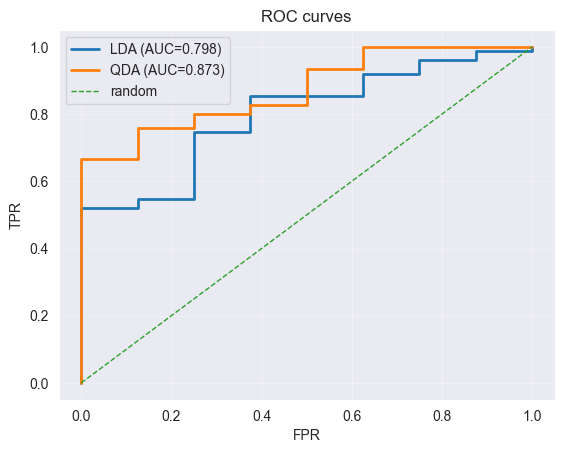

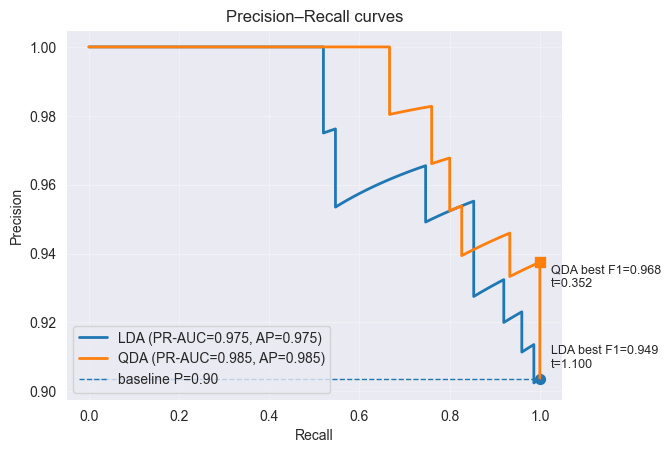

LDA:  ROC-AUC=0.7983  PR-AUC=0.9749  AP=0.9751  bestF1=0.9494 at t=1.100
QDA:  ROC-AUC=0.8733  PR-AUC=0.9853  AP=0.9854  bestF1=0.9677 at t=0.352


In [38]:
y_score_lda = clf.predict_proba(X_test)[:, 1] 
y_score_qda = qda.predict_proba(X_test)[:, 1]

def curves_and_best_f1(y_true, y_score):
    # ROC
    fpr, tpr, thr_roc = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    # PR
    prec, rec, thr_pr = precision_recall_curve(y_true, y_score)
    pr_auc = auc(rec, prec)
    ap = average_precision_score(y_true, y_score)

    # Лучшая F1 на PR (по всем точкам кривой)
    f1s = 2 * prec * rec / (prec + rec + 1e-12)
    i_best = int(np.nanargmax(f1s))
    # соответствующий порог: для точки i>0 берём thr_pr[i-1], для i=0 порог формально > max(score)
    t_best = (thr_pr[i_best-1] if i_best > 0 else 1.1)


    return {
        "roc": (fpr, tpr, roc_auc),
        "pr": (rec, prec, pr_auc, ap),
        "best": {"idx": i_best, "rec": rec[i_best], "prec": prec[i_best], "f1": f1s[i_best], "thr": t_best}
    }

lda_stats = curves_and_best_f1(y_test, y_score_lda)
qda_stats = curves_and_best_f1(y_test, y_score_qda)

# ROC: both models
fig = plt.figure()
plt.plot(lda_stats["roc"][0], lda_stats["roc"][1], lw=2, label=f"LDA (AUC={lda_stats['roc'][2]:.3f})")
plt.plot(qda_stats["roc"][0], qda_stats["roc"][1], lw=2, label=f"QDA (AUC={qda_stats['roc'][2]:.3f})")
plt.plot([0,1], [0,1], "--", lw=1, label="random")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curves"); plt.legend(); plt.grid(alpha=0.3)
plt.show()

# PR: both models + top-F1
fig = plt.figure()
plt.plot(lda_stats["pr"][0], lda_stats["pr"][1], lw=2,
         label=f"LDA (PR-AUC={lda_stats['pr'][2]:.3f}, AP={lda_stats['pr'][3]:.3f})")
plt.plot(qda_stats["pr"][0], qda_stats["pr"][1], lw=2,
         label=f"QDA (PR-AUC={qda_stats['pr'][2]:.3f}, AP={qda_stats['pr'][3]:.3f})")

# top-F1
bL = lda_stats["best"]; bQ = qda_stats["best"]
plt.scatter([bL["rec"]], [bL["prec"]], s=50, marker="o")
plt.scatter([bQ["rec"]], [bQ["prec"]], s=50, marker="s")
plt.annotate(f"LDA best F1={bL['f1']:.3f}\nt={bL['thr']:.3f}",
             (bL["rec"], bL["prec"]), textcoords="offset points", xytext=(8,8), fontsize=9)
plt.annotate(f"QDA best F1={bQ['f1']:.3f}\nt={bQ['thr']:.3f}",
             (bQ["rec"], bQ["prec"]), textcoords="offset points", xytext=(8,-18), fontsize=9)

baseline = y_test.mean()
plt.hlines(baseline, 0, 1, linestyles="--", lw=1, label=f"baseline P={baseline:.2f}")

plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall curves")
plt.legend(); plt.grid(alpha=0.3)
plt.show()

print(f"LDA:  ROC-AUC={lda_stats['roc'][2]:.4f}  PR-AUC={lda_stats['pr'][2]:.4f}  AP={lda_stats['pr'][3]:.4f}  bestF1={bL['f1']:.4f} at t={bL['thr']:.3f}")
print(f"QDA:  ROC-AUC={qda_stats['roc'][2]:.4f}  PR-AUC={qda_stats['pr'][2]:.4f}  AP={qda_stats['pr'][3]:.4f}  bestF1={bQ['f1']:.4f} at t={bQ['thr']:.3f}")

Посчитайте и сравните ROC AUC и PR AUC для LDA и QDA.

In [40]:
y_score_lda = clf.predict_proba(X_test)[:, 1]
y_score_qda = qda.predict_proba(X_test)[:, 1]

# ROC AUC
roc_auc_lda = roc_auc_score(y_test, y_score_lda)
roc_auc_qda = roc_auc_score(y_test, y_score_qda)

# PR AUC and AP 
prec_l, rec_l, _ = precision_recall_curve(y_test, y_score_lda)
prec_q, rec_q, _ = precision_recall_curve(y_test, y_score_qda)

pr_auc_lda = auc(rec_l, prec_l)
pr_auc_qda = auc(rec_q, prec_q)

ap_lda = average_precision_score(y_test, y_score_lda)
ap_qda  = average_precision_score(y_test, y_score_qda)

print(f"LDA: ROC AUC = {roc_auc_lda:.4f} | PR AUC = {pr_auc_lda:.4f} | AP = {ap_lda:.4f}")
print(f"QDA: ROC AUC = {roc_auc_qda:.4f} | PR AUC = {pr_auc_qda:.4f} | AP = {ap_qda:.4f}")

res = pd.DataFrame({
    "model": ["LDA","QDA"],
    "ROC AUC": [roc_auc_lda, roc_auc_qda],
    "PR AUC": [pr_auc_lda, pr_auc_qda],
    "AP": [ap_lda, ap_qda]
})
print("\nСравнение на тесте:")
print(res.to_string(index=False))


print(f"\nΔ(ROC AUC) QDA-LDA = {roc_auc_qda - roc_auc_lda:+.4f}")
print(f"Δ(PR  AUC) QDA-LDA = {pr_auc_qda - pr_auc_lda:+.4f}")

LDA: ROC AUC = 0.7983 | PR AUC = 0.9749 | AP = 0.9751
QDA: ROC AUC = 0.8733 | PR AUC = 0.9853 | AP = 0.9854

Сравнение на тесте:
model  ROC AUC   PR AUC       AP
  LDA 0.798333 0.974854 0.975059
  QDA 0.873333 0.985307 0.985415

Δ(ROC AUC) QDA-LDA = +0.0750
Δ(PR  AUC) QDA-LDA = +0.0105


Какой из классификаторов справился лучше? Подумайте, почему так

Your answer here

## Задача 3

Для начала давайте познакомимся с [логистической регрессией](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), подключим её из библиотеки

In [ ]:
from sklearn.linear_model import LogisticRegression

Теперь сгенерируем два нормальных распределения и попробуем разделить их

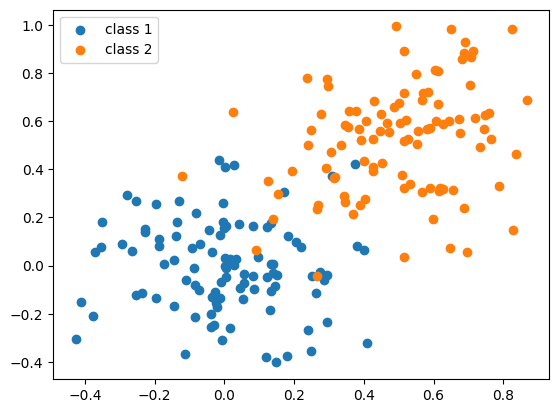

In [ ]:
df = pd.DataFrame()
X1 = np.random.normal(0, 0.2, (100, 2))
X2 = np.random.normal(0.5, 0.2, (100, 2))
df["x"] = np.hstack([X1[:, 0], X2[:, 0]])
df["y"] = np.hstack([X1[:, 1], X2[:, 1]])
df["label"] = np.hstack([np.zeros(100), np.ones(100)])
plt.scatter(df[df["label"] == 0]["x"], df[df["label"] == 0]["y"], label="class 1")
plt.scatter(df[df["label"] == 1]["x"], df[df["label"] == 1]["y"], label="class 2")
plt.legend()
plt.show()

Создадим классификатор,обучим его и посмотрим на качество классификации

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(df[['x', 'y']], df['label'])
print("accuracy:", log_reg.score(df[['x', 'y']], df['label']))

accuracy: 0.96


Как и LDA, логистическая регрессия строит рязделяющую прямую, её коэффициенты можно получить из модели с помощью полей *.coef_* и *.intercept_*

Теперь постройте на исходных данных разделяющую прямую

In [ ]:
#Your code here

Аналогично линейной, логистическая регрессия может использовать регуляризацию при построении разделяющей прямой, за это отвечает параметр *penalty*, величину штрафа регулирует параметр *С*. Подробнее об этом можно посмотреть в [документаци](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Используйте L1, L2 и ElasticNet регуляризацию, попробуйте разные значения параметра *C*, изобразите на одном рисунке исходные данные и все четыре разделющие прямые: с и без регуляризации

In [ ]:
#Your code here

В каком случае получается наилучшее разделение?

Your answer here

### Сравнение Логистической регрессии, LDA и QDA

Смоделируйте для двух классов размера 100 из распределений в $\mathbb{R}^2$: $(X_i, Y_i)$, $X_i ∼ 𝑅[−1, 1]$, $Y_i = X_i + Z_i$, где $Z_i ∼ Laplace(-1, 0.5)$ для первого класса и $Z_i ∼ Laplace(1, 0.5)$ для второго

In [ ]:
#Your code here

Запустите [логистический классификатор](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) и [QDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html)

In [ ]:
#Your code here

Изобразите три [ROC–кривые](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) и три [PR–кривые](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)

In [ ]:
#Your code here

Выберите значения 𝑡 для каждого из трех классификаторов, оптимизируя [𝐹1–меру](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

In [ ]:
#Your code here

Нарисуйте облака точек на плоскости и три разделяющие кривые

In [ ]:
#Your code here

Какой из классификаторов справился лучше и почему?

Your answer here

## Задача 4

Загрузите данные из файла mroz.txt (описания переменных приведены в файле mroz.des)

Ваша задача — определить по данным женщины, работает ли она или нет (переменная inlf, равная $1$, если работает).

`Не используйте` переменные hours (количество рабочих часов — переменная равна нулю для неработающих), wage (заработок женщины), repwage (ответ на вопрос о величине дохода женщины) и lwage (логарифм переменной wage).

Разбейте выборку на [train, validation и test sets](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Разные классификаторы сравнивайте на validation set. Классификатор, выбранный вами наилучшим, тестируйте на test set.

In [ ]:
#Your code here